# TRADING

Ce notebook contient des approches obsolètes précédentes pour les algorithmes de Q learning pour les achats et ventes d'actions. 

In [1]:
from numpy.random import default_rng

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform


In [7]:
thales = pd.read_excel('thales_historical.xlsx')

In [8]:
thales

,Date,Open,High,Low,Close,Volume
0,24 03 2023,135.950,136.000,134.200,135.100,244637
1,23 03 2023,135.150,137.050,134.750,136.350,265563
2,22 03 2023,133.900,135.600,133.150,135.200,221184
3,21 03 2023,132.850,135.250,132.000,133.900,287586
4,20 03 2023,129.800,132.250,127.850,132.250,275474
...,...,...,...,...,...,...
2561,03 04 2013,33.590,33.680,33.000,33.015,224903
2562,02 04 2013,33.095,33.855,33.070,33.855,319696
2563,28 03 2013,32.745,33.045,32.480,32.995,335531
2564,27 03 2013,32.615,32.630,32.315,32.565,171238


In [9]:
thales = thales["Open"]


In [14]:
def action(state): 
    i = int(state/10)
    j = 10-i
    vector = np.zeros((21))
    vector[10-i:10]=1
    vector[10:11+j]=1
    return vector

In [15]:
action(50)

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0.])

In [16]:
action(20)
len(thales)

2566

Notre première fonction prenait en compte qu'une seule action et ne prenait pas en compte le cours des actions

In [17]:
def choix_action(state, Q):
    # Choisit une action à partir de l'êtat du système et la matrice Q
    a = action(state)
    new_state = 0
    j = 0
    s = int(state/10)
    max = -10
    for i in range(len(a)):
        u = uniform(0,1)
        if u * Q[s][i] < max and a[i] == 1:
            j = i
            max=Q[s][i]
            new_state = state + (-100+i*10)
    return new_state, j

In [18]:
def diff(state,new_state,Q,a):
    max = -10
    c = Q[int(state/10)][a]
    for i in range(21):
        if Q[int(new_state/10)][i] - c >= max:
            max = Q[int(new_state/10)][i]-c
    return max

In [19]:
def init_Q(Q):
    for i in range(11):
        a = action(i*10)
        for j in range(len(a)):
            if a[j]==0:
                Q[i][j]=0
    return Q

In [20]:
Q = default_rng(70).random((11,21))
Q = init_Q(Q)

In [21]:
def qlearning(state0, data, alpha, gamma): # alpha : pas de l'algorithme; gamma : hyperparamètre
    Q = default_rng(70).random((11,21))
    Q = init_Q(Q)
    n = len(data)
    state = state0
    liste_state = []
    # boucle
    for k in range(1,n):
        a = action(state)
        new_state = choix_action(state,Q)[0]
        indice_action = choix_action(state,Q)[1]
        # update
        R = new_state*data[k]-state*data[k-1] + (state - new_state)*data[k-1] # ce qu'on a perdu ou gagné à l'étape (reward)
        difference = diff(state,new_state,Q,indice_action)
        Q[int(state/10)][indice_action] += alpha*(R+gamma*difference)
        state = new_state
        liste_state.append(state)
    return Q, liste_state

In [22]:
Q, liste_state = qlearning(10,thales,0.5,1)

In [ ]:
plt.plot(liste_state[1000:1100])

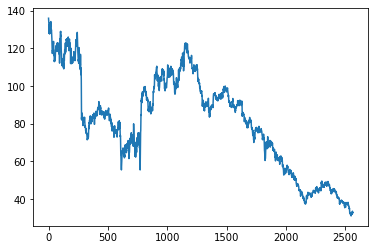

In [25]:
plt.plot(thales)

On ajoute maintenant le niveau des actions dans le choix de la décision de l'algorithme 


In [26]:
def initQ2(state0):
    
    # L'état est de la forme nombre d'actions + prix des actions 
    # On oblige la quantité d'action possible à être égale au nombre d'êtat du prix des action pour des raisons d'implémentation
    # Nombre d'êtat = 4 = tranche de 25%
    n_action = int((len(state0) - 1)/2)
    n_action = int(n_action*2)
    Q = default_rng(70).random((10**n_action,10**n_action))
    
    return Q   


In [28]:
def state_to_indice(state,n_action):
    # On prend un êtat et on retourne sa place dans la matrice Q 
    # Passage d'une base 11 à une base 1
    indice = 0 
    for k in range(n_action):
        indice += state[k] * 11**k
    return int(indice)

In [29]:
def indice_to_action(indice,n_action):
    # On prend une place dans la matrice Q  et on retourne l'êtat correspondant 
    # Passage d'une base 1 à une base 11
    action = []
    for k in range(n_action-1,-1,-1):
        terme = indice // 11**(k)
        action.insert(0,terme)
        indice = indice - terme * 11**k
    return(action)


In [30]:
def action_possible(state,action,budget):
    # On vérifie si notre transaction est possible avec le budget hors action qu'il nous reste
    possible = False
    depense = 0 
    n_action = len(action)
    for k in range(n_action):
        depense =  depense + (action[k] - state[k])*state[n_action + k]
    if budget >= depense:
        possible = True
    return(possible) 

In [31]:
def choix_action2(state,Q,valeurs):
    # On choisit l'action avec le max de Q et qui est possible
    new_state = [0]*len(state)
    n_action = int((len(state) - 1)/2)
    new_state[n_action:] = valeurs
    budget = state[-1]
    j = 0
    s = state_to_indice(state,n_action)
    max = -10
    for i in range(11**n_action):
        # On ajoute un peu d'aléatoire
        action = indice_to_action(i,n_action)
        possible = action_possible(state,action,budget)
        if Q[s][i] >= max and possible == True:
            j = i
            max=Q[s][i]
            new_state[0:n_action] = action
    return new_state, j

In [32]:
[0]*5

[0, 0, 0, 0, 0]

In [33]:
def reward(new_state,state,n_action):
    # Calcul de la récompense c'est à dire notre argent après les transactions
    R = new_state[-1] 
    for k in range(n_action):
        R += new_state[k]*new_state[n_action + k] - state[k]*state[n_action + k] 
    return(R)

In [34]:
def diff(state,new_state,Q,a):
    # Calcul d'un terme de changement de la matrice Q 
    n_action = int((len(state) - 1)/2)
    indice1 = state_to_indice(state,n_action)
    max = -10
    c = Q[indice1][a]
    for i in range(21):
        if Q[indice1][i] - c >= max:
            max = Q[int(indice1)][i]-c
    return max

In [35]:
def make_new_state(new_state,state,n_action):
    # Créé le nouvel êtat à partir de l'action choisit 
    state2 = state
    budget2 = state[-1]
    for k in range(n_action):
        state2[k] = new_state[k]
        budget2 = budget2 + (new_state[k] - state[k])*state[n_action + k]
    state2[-1] = budget2
    return(state2)

In [36]:
def qlearning2(state0, data, alpha, gamma): # alpha : pas de l'algorithme; gamma : hyperparamètre à la con
    Q = initQ2(state0)
    n_action = int((len(state0) - 1)/2)
    state = state0
    liste_state = []
    # boucle
    for k in range(1,len(data)):
        new_state = choix_action2(state,Q,data[k])[0]

        new_state[n_action:] = data[k] 
        indice_action = choix_action2(state,Q,data[k])[1]

        # update
        R = reward(new_state,state,n_action) # ce qu'on a perdu ou gagné à l'étape (reward)

        difference = diff(state,new_state,Q,indice_action)

        indice1 = state_to_indice(state,n_action)

        Q[indice1][indice_action] += alpha*(R+gamma*difference)

        state = make_new_state(new_state,state,n_action)

        liste_state.append(state)
    return Q, liste_state

In [37]:
# On test l'algorithme de Q learning 
stocks = pd.read_csv('all_stocks_5yr.csv')


In [38]:
stocks = stocks.drop(['date', 'open', 'high', 'low', 'volume'], axis=1) 
stocks

,close,Name
0,14.75,AAL
1,14.46,AAL
2,14.27,AAL
3,14.66,AAL
4,13.99,AAL
...,...,...
619035,77.82,ZTS
619036,76.78,ZTS
619037,73.83,ZTS
619038,73.27,ZTS


In [39]:
stocksAAL = stocks.loc[stocks['Name'] == "AAL"]
stocksAAL = stocksAAL["close"].values.tolist()
stocksZTS = stocks.loc[stocks['Name'] == "ZTS"]
stocksZTS = stocksZTS["close"].values.tolist()

data = []
for k in range(len(stocksAAL)) : 
    data.append([stocksAAL[k],stocksZTS[k]])

In [40]:
state0 = [0,0,10,10,100]
trajectoire = qlearning2(state0,data, 0.5, 0.5)[1]
Q =  qlearning2(state0,data, 0.5, 0.5)[0]
